In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from collections import defaultdict
from itertools import product
from functools import wraps
import json
import re

In [3]:
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from joblib import delayed, Parallel
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
import utils

In [5]:
scenarios = ['tip_x=0um_y=+250um_sigma=0.5', 'Original_DB', 'tip_x=0um_y=-250um_sigma=0.5']
clusters, tracks, residuals, particles = utils.load(scenarios)

In [6]:
sigma = {
    0.5: 0.382924922548026,
    1: 0.682689492137086,
    2: 0.954499736103642,
    3: 0.997300203936740
}
bins = np.linspace(-0.2, 0.2, 100)
sns.set_palette(sns.color_palette('colorblind', len(scenarios)))
sns.set_style('whitegrid')

In [7]:
particles.scenario.cat.categories

Index(['tip_x=0um_y=+250um_sigma=0.5', 'Original_DB',
       'tip_x=0um_y=-250um_sigma=0.5'],
      dtype='object')

## $x/y/z$ residuals

Here the residual is plotted between:
 - The cluster position in the true geometry
 - The point of closest approach for the track reconstuced in the misaligned geometry

As you might expect this only (appreciably) affects the residual in $x$ for rotations around $y$

(-0.20000000000000001, 0.20000000000000001)

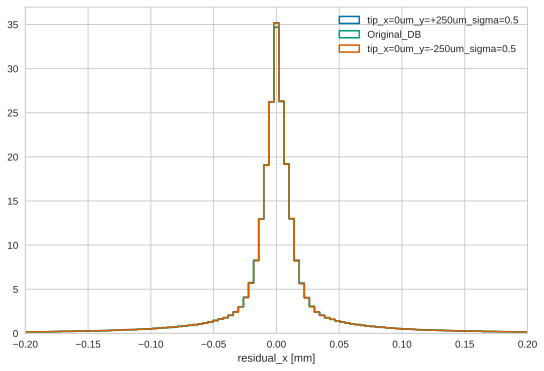

In [8]:
for scenario in scenarios:
    residuals[scenario].residual_x.hist(
        bins=bins, histtype='step', lw=1.5, normed=True, label=scenario)
plt.legend(loc='best')
plt.xlabel('residual_x [mm]')
plt.xlim((bins[0], bins[-1]))

(-0.20000000000000001, 0.20000000000000001)

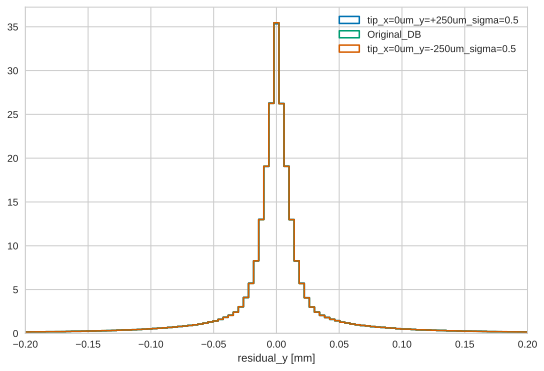

In [9]:
for scenario in scenarios:
    residuals[scenario].residual_y.hist(
        bins=bins, histtype='step', lw=1.5, normed=True, label=scenario)
plt.legend(loc='best')
plt.xlabel('residual_y [mm]')
plt.xlim((bins[0], bins[-1]))

(-0.20000000000000001, 0.20000000000000001)

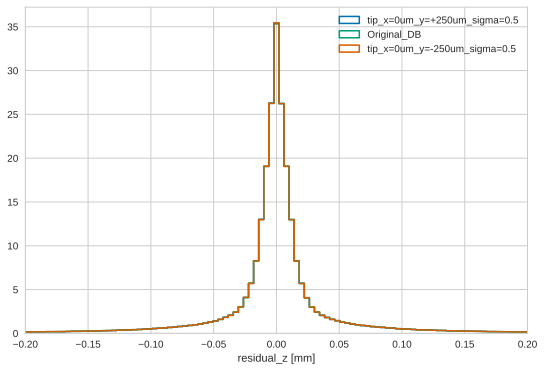

In [10]:
for scenario in scenarios:
    residuals[scenario].residual_y.hist(
        bins=bins, histtype='step', lw=1.5, normed=True, label=scenario)
plt.legend(loc='best')
plt.xlabel('residual_z [mm]')
plt.xlim((bins[0], bins[-1]))

## $x/y/z$ residuals as a function of VP station

Here I plot the $x/y/z$ residuals (above) as a function of VP station. The coutour lines corrosponding to the median, $\pm1\sigma$ and $\pm2\sigma$ are shown, where the values are obtained by taking the percentiles of the residual distribution.

I also plot the true residual, which is the residual between the true cluster location (using nominal geometry) and the track.

In [11]:
station_positions = {
    0: -281.25, 1: -256.25, 2: -231.25, 3: -206.25, 4: -131.25, 5: -56.25, 6: -31.25,
    7: -6.25, 8: 18.75, 9: 43.75, 10: 68.75, 11: 93.75, 12: 118.75, 13: 143.75,
    14: 168.75, 15: 193.75, 16: 218.75, 17: 243.75, 18: 268.75, 19: 318.75,
    20: 393.75, 21: 493.75, 22: 593.75, 23: 643.75, 24: 693.75, 25: 743.75
}

In [12]:
def _get_ys(scenario, var, side):
    _var = var[[0, len('true_')][scenario == 'Original_DB' and var.startswith('true_')]:]
    rs = residuals[scenario]
    if side is not None:
        rs = rs.query(f'module % 2 == {side}')
    rs = rs.groupby('station', sort=True)[_var]
    ys = rs.quantile([0.5+sigma[2]/2, 0.5+sigma[1]/2, 0.5, 0.5-sigma[1]/2, 0.5-sigma[2]/2])
    return (scenario, side), ys

def plot_residual(var, vs_station=False, sides=None):
    plt.figure()
    sides = sides or list(zip(scenarios, [None]*len(scenarios)))
    stations = residuals['Original_DB'].station.cat.categories.values
    alphas = [0.25, 0.75, 1, 0.75, 0.25]
    linestyles = [':', '--', '-', '--', ':']

    xs = [[station_positions[x] for x in stations], stations][vs_station]
    ys = dict(Parallel(n_jobs=len(scenarios), backend='threading')(
        delayed(_get_ys)(scenario, var, side=side) for scenario, side in sides
    ))

    for (scenario, side), colour in zip(sides, sns.color_palette(n_colors=len(scenarios)*len(sides))):
        lines = []
        for (quantile, y), a, ls in zip(ys[(scenario, side)].groupby(level=1, sort=True), alphas, linestyles):
            label = [None, scenario if side is None else f'{scenario} - {["even", "odd"][side]}'][quantile == 0.5]
            l, = plt.plot(xs, y.values, c=colour, alpha=a, ls=ls, label=label)
            lines.append(l)

        if scenario == 'Original_DB':
            sigma_legend = plt.legend(lines[:3], ['±2σ', '±1σ', 'median'], loc='lower left')

    plt.legend(loc='best')
    plt.gca().add_artist(sigma_legend)
    plt.xlim((0, 25) if vs_station else (station_positions[0], station_positions[25]))
    plt.xlabel('z [mm]')
    plt.ylabel(f'{var} [mm]')
    ylim = abs(max(plt.ylim()))
    plt.ylim((-ylim, ylim))

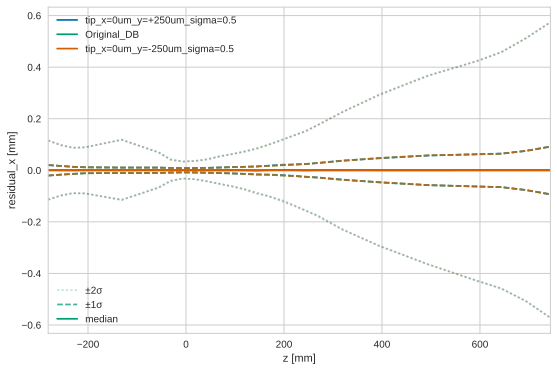

In [13]:
plot_residual('residual_x')

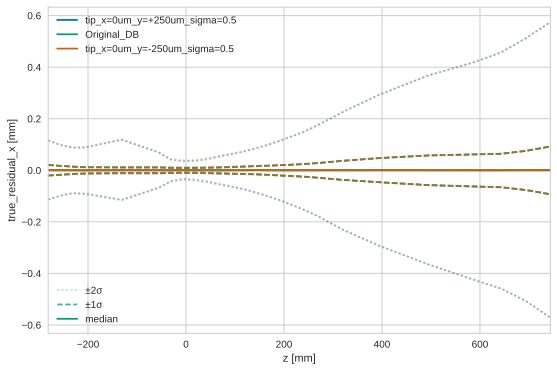

In [14]:
plot_residual('true_residual_x')

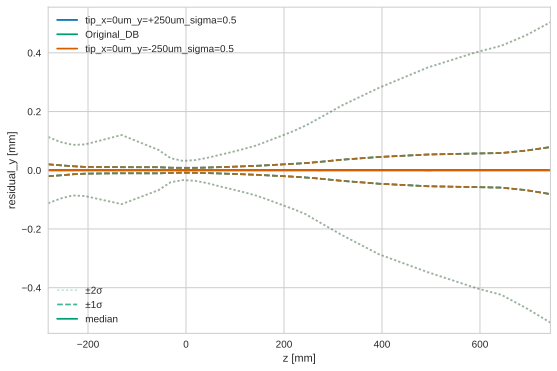

In [15]:
plot_residual('residual_y')

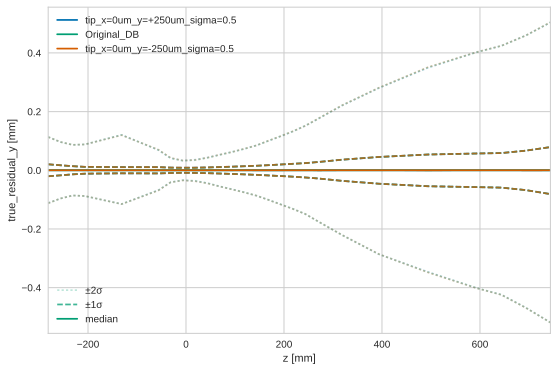

In [16]:
plot_residual('true_residual_y')

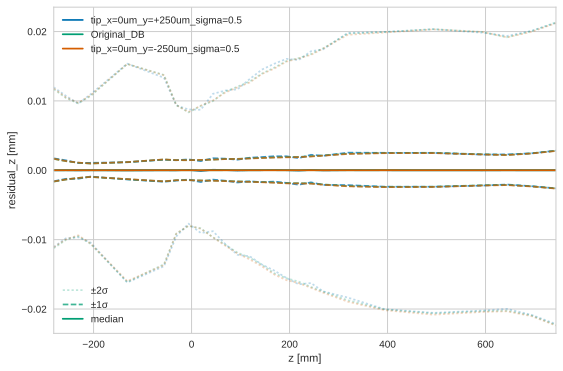

In [17]:
plot_residual('residual_z')

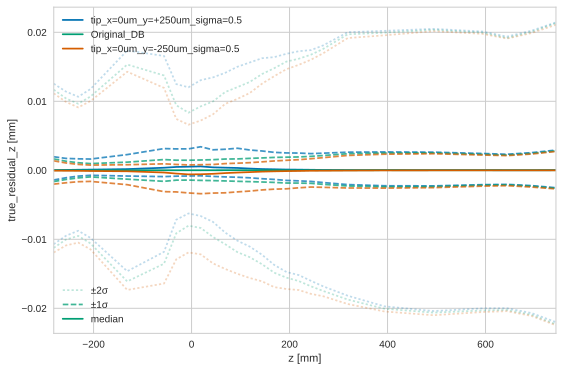

In [18]:
plot_residual('true_residual_z')

### And try splitting tracks by side

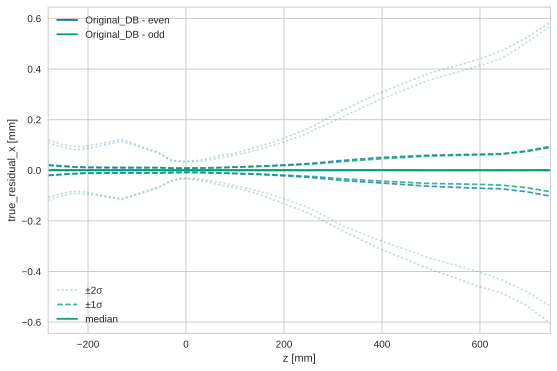

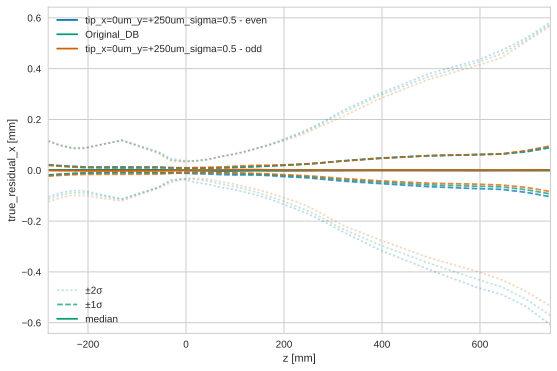

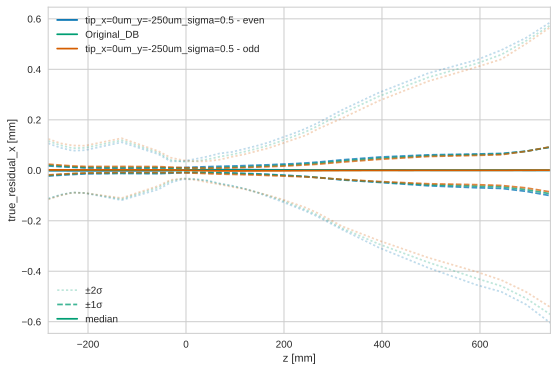

In [19]:
plot_residual('true_residual_x', sides=[('Original_DB', 0), ('Original_DB', 1)])
plot_residual('true_residual_x', sides=[(scenarios[0], 0), ('Original_DB', None), (scenarios[0], 1)])
plot_residual('true_residual_x', sides=[(scenarios[2], 0), ('Original_DB', None), (scenarios[2], 1)])

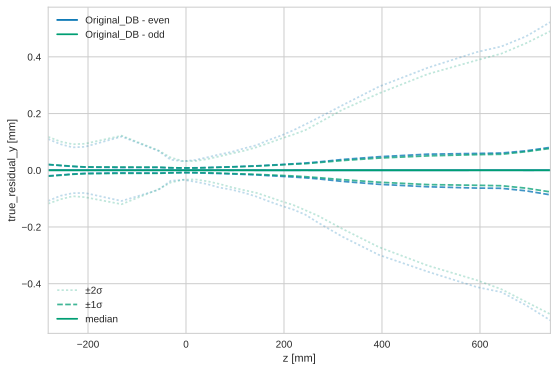

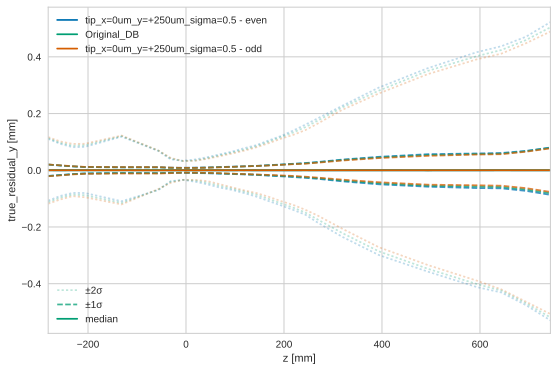

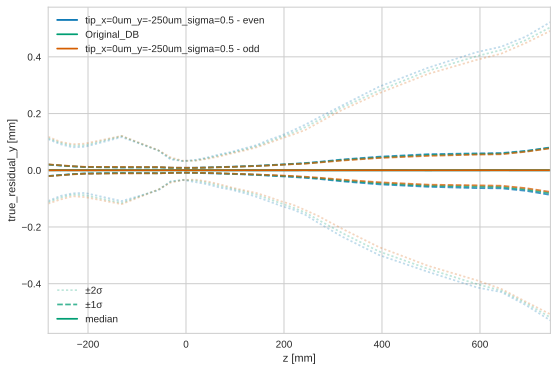

In [20]:
plot_residual('true_residual_y', sides=[('Original_DB', 0), ('Original_DB', 1)])
plot_residual('true_residual_y', sides=[(scenarios[0], 0), ('Original_DB', None), (scenarios[0], 1)])
plot_residual('true_residual_y', sides=[(scenarios[2], 0), ('Original_DB', None), (scenarios[2], 1)])

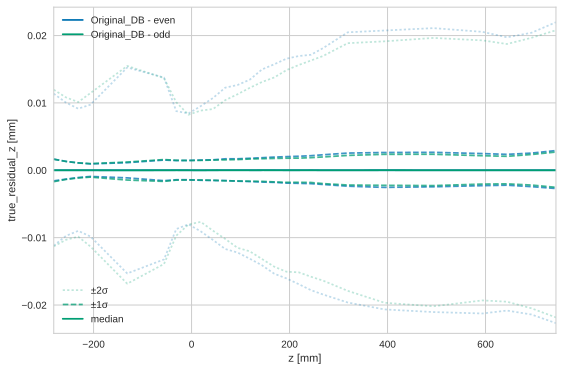

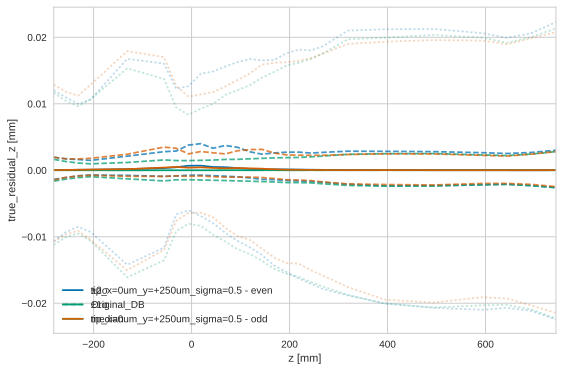

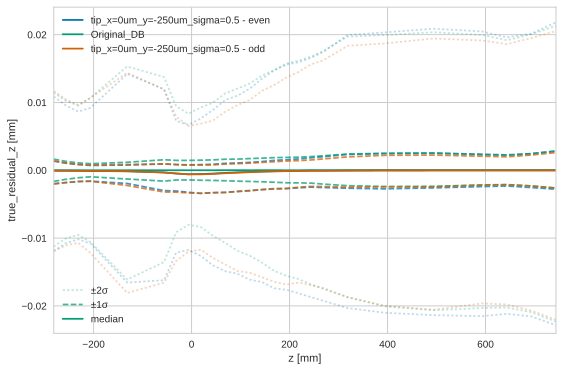

In [21]:
plot_residual('true_residual_z', sides=[('Original_DB', 0), ('Original_DB', 1)])
plot_residual('true_residual_z', sides=[(scenarios[0], 0), ('Original_DB', None), (scenarios[0], 1)])
plot_residual('true_residual_z', sides=[(scenarios[2], 0), ('Original_DB', None), (scenarios[2], 1)])

## Momentum resolution of all long tracks

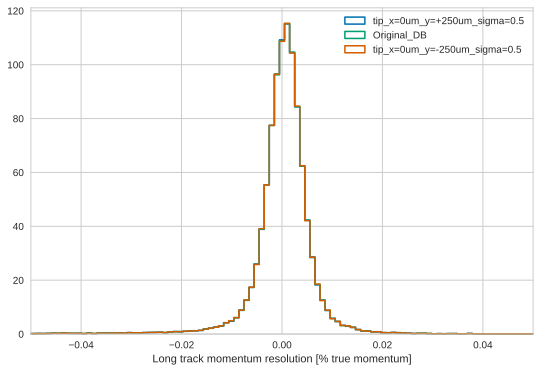

In [22]:
for scenario in scenarios:
    long_tracks = tracks.query(f'(scenario == "{scenario}") & (track_type == "Long")')
    resolution = long_tracks.eval('(p-true_p)/true_p').dropna()
    resolution.hist(bins=np.linspace(-0.05, 0.05, 100), histtype='step', lw=1.5, label=scenario, normed=True)
plt.legend(loc='best')
plt.xlim((-0.05, 0.05))
plt.xlabel('Long track momentum resolution [% true momentum]')

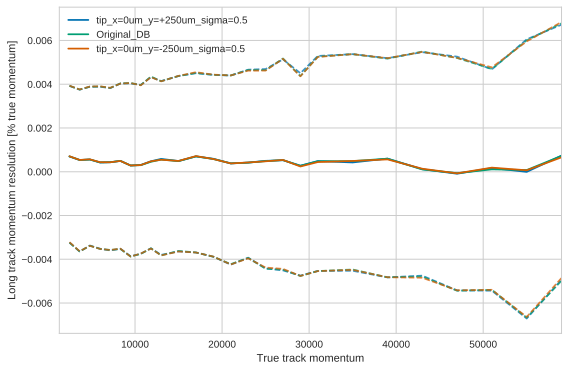

In [23]:
for scenario, colour in zip(scenarios, sns.color_palette(n_colors=len(scenarios))):
    long_tracks = tracks.query(f'(scenario == "{scenario}") & (track_type == "Long")')
    # Use a variable binning to avoid issues with low stats
    xs = np.concatenate([
        np.linspace(1300, 13000, 11),
        np.arange(15000, 31001, 2000),
        np.arange(35000, 61000, 4000)
    ])
    ys = []
    for p_low, p_high in utils.pairwise(xs):
        resolution = long_tracks.query(f'({p_low} <= true_p) & (true_p < {p_high})')
        resolution = resolution.eval('(p-true_p)/true_p').dropna()
        if len(resolution) < 50:
            print(p_low, scenario, len(resolution))
        ys.append([
            resolution.quantile(0.5+sigma[1]/2),
            resolution.median(),
            resolution.quantile(0.5-sigma[1]/2)
        ])

    for y, alpha, ls in zip(zip(*ys), [0.75, 1, 0.75], ['--', '-', '--']):
        plt.plot(xs[:-1]+np.diff(xs), y, c=colour, alpha=alpha, ls=ls, label=(scenario if alpha == 1 else None))

plt.legend(loc='best')
plt.xlim((xs[0], xs[-1]))
plt.xlabel('True track momentum')
plt.ylabel('Long track momentum resolution [% true momentum]')

## $D^0$ vertex fit quality

Here $D^{*+} \rightarrow \left(D^0 \rightarrow K^+ K^- \right) \pi^+$ candidates are reconstructed by:
 - Truth matching tracks (created with NoPIDsParticleMaker) to ensure that all hits on a final state track are assoiated with the same MCParticle
 - The mother of both kaons is then required to be the same MCParticle
 - The mother of the pion must be the same as the mother of the mother of the kaons

The vertex is then fitted using `LoKi::VertexFitter` to build a $D^0$

TODO:
 - Do I need to worry if the mother of the kaon MCParticles is something other than a $D^0$ (so $D^0 \rightarrow X
\rightarrow K^+ K^-)$?
 - Likewise for the $D^{*+}$?

30 (7.2%) events clipped for tip_x=0um_y=+250um_sigma=0.5
   0.5σ = 0.073
   1σ   = 0.241
   2σ   = 0.532
29 (6.9%) events clipped for Original_DB
   0.5σ = 0.080
   1σ   = 0.209
   2σ   = 0.482
30 (7.1%) events clipped for tip_x=0um_y=-250um_sigma=0.5
   0.5σ = 0.070
   1σ   = 0.217
   2σ   = 0.448


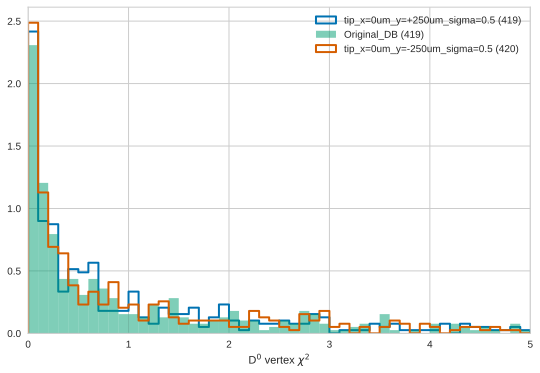

In [24]:
for scenario in scenarios:
    chi2 = particles.query(f'scenario == "{scenario}"').vertex_chi2
    label = f'{scenario} ({len(chi2)})'
    if scenario == 'Original_DB':
        chi2.hist(bins=np.linspace(0, 5, 51), label=label, alpha=0.5, normed=True)
    else:
        chi2.hist(bins=np.linspace(0, 5, 51), label=label, normed=True, histtype='step', lw=2)
    print(f'{sum(chi2 > 5)} ({sum(chi2 > 5)/len(chi2):.1%}) events clipped for {scenario}')
    # Print sigma values for if this was one side of a normal distribution
    print(f'   0.5σ = {chi2.quantile(sigma[0.5]/2):.3f}')
    print(f'   1σ   = {chi2.quantile(sigma[1]/2):.3f}')
    print(f'   2σ   = {chi2.quantile(sigma[2]/2):.3f}')
plt.legend(loc='best')
plt.xlim((0, 5))
plt.xlabel('D$^0$ vertex $\chi^2$')

## Flight distance resolution

The flight distance is taken to be the distance between the reconstructed $D^0$ vertex (above) and the true $D^{*+}$ origin vertex. I **do not** consider if the $D^{*+}$ is promptly produced.

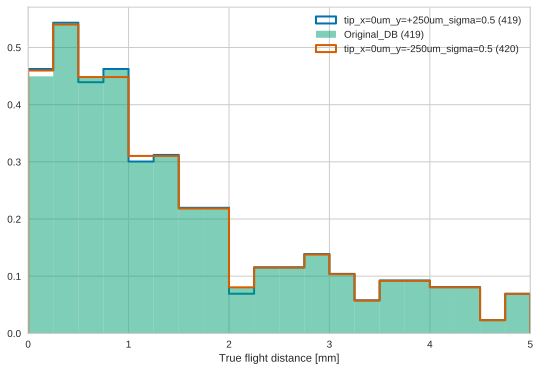

In [25]:
for scenario in scenarios:
    true_fd = particles.query(f'(scenario == "{scenario}")').true_fd
    label = f'{scenario} ({len(true_fd)})'
    if scenario == 'Original_DB':
        true_fd.hist(bins=np.linspace(0, 5, 21), label=label, alpha=0.5, normed=True)
    else:
        true_fd.hist(bins=np.linspace(0, 5, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 5))
plt.xlabel('True flight distance [mm]')

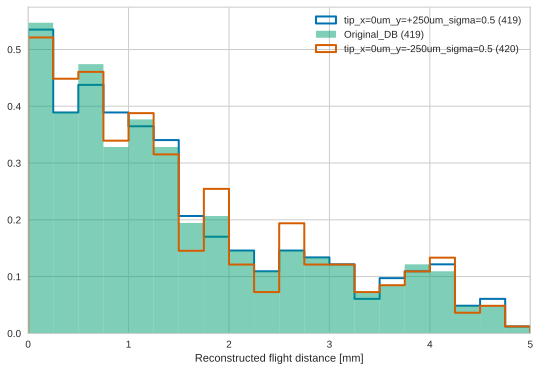

In [26]:
for scenario in scenarios:
    reco_fd = particles.query(f'(scenario == "{scenario}")').fd
    label = f'{scenario} ({len(reco_fd)})'
    if scenario == 'Original_DB':
        reco_fd.hist(bins=np.linspace(0, 5, 21), label=label, alpha=0.5, normed=True)
    else:
        reco_fd.hist(bins=np.linspace(0, 5, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 5))
plt.xlabel('Reconstructed flight distance [mm]')

tip_x=0um_y=+250um_sigma=0.5 17
  median = -0.044
    0.5σ = 0.367
      1σ = 0.944
Original_DB 17
  median = -0.046
    0.5σ = 0.354
      1σ = 0.936
tip_x=0um_y=-250um_sigma=0.5 17
  median = -0.050
    0.5σ = 0.367
      1σ = 0.936


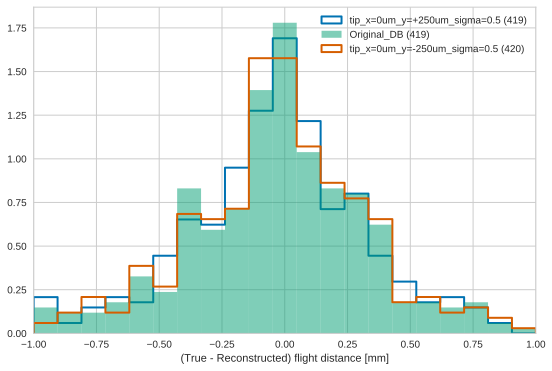

In [27]:
for scenario in scenarios:
    _particles = particles.query(f'(scenario == "{scenario}")')
    reco_fd = _particles.fd
    true_fd = _particles.true_fd
    res = true_fd - reco_fd
    print(scenario, sum(res > 1))
    print(f'  median = {res.median():.3f}')
    print(f'    0.5σ = {res.quantile(0.5+sigma[0.5]/2)-res.quantile(0.5-sigma[0.5]/2):.3f}')
    print(f'      1σ = {res.quantile(0.5+sigma[1]/2)-res.quantile(0.5-sigma[1]/2):.3f}')
    label = f'{scenario} ({len(res)})'
    if scenario == 'Original_DB':
        res.hist(bins=np.linspace(-1, 1, 22), label=label, alpha=0.5, normed=True)
    else:
        res.hist(bins=np.linspace(-1, 1, 22), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((-1, 1))
plt.xlabel('(True - Reconstructed) flight distance [mm]')

## D0 lifetime

Using reconstructed momentum of the $D^0$ in all cases.

$\gamma = \frac{1}{\sqrt{1+\frac{p}{m\left(D^0\right)}^2}}$

$t_{\text{proper}} = \frac{\text{FD}*\gamma}{c}$

In [28]:
particles.eval(f'proper_time = (fd/1000 * D0_gamma) /{utils.speed_of_light}', inplace=True)
particles.eval(f'true_proper_time = (true_fd/1000 * D0_gamma) /{utils.speed_of_light}', inplace=True)

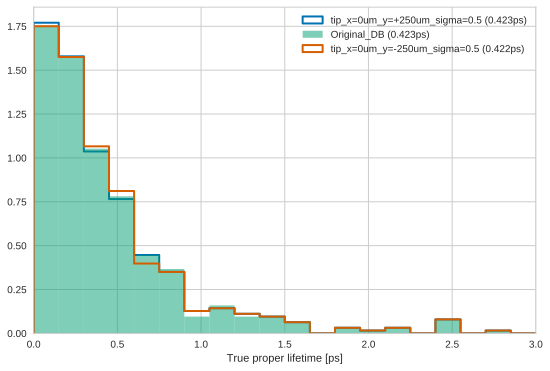

In [29]:
for scenario in scenarios:
    lt = particles.query(f'(scenario == "{scenario}")').true_proper_time*1e12
    label = f'{scenario} ({lt.quantile(1 - 1/np.exp(1)):.3f}ps)'
    if scenario == 'Original_DB':
        lt.hist(bins=np.linspace(0, 3e-0, 21), label=label, alpha=0.5, normed=True)
    else:
        lt.hist(bins=np.linspace(0, 3e-0, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 3e-0))
plt.xlabel('True proper lifetime [ps]')

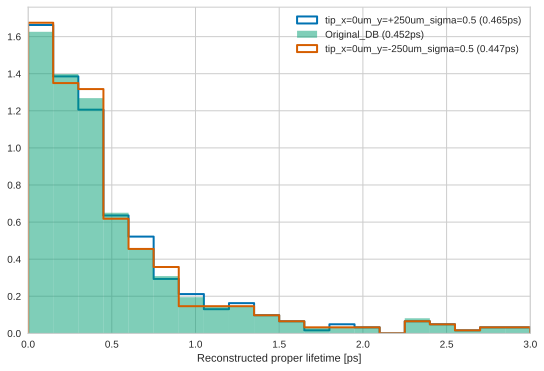

In [30]:
for scenario in scenarios:
    lt = particles.query(f'(scenario == "{scenario}")').proper_time*1e12
    label = f'{scenario} ({lt.quantile(1 - 1/np.exp(1)):.3f}ps)'
    if scenario == 'Original_DB':
        lt.hist(bins=np.linspace(0, 3e0, 21), label=label, alpha=0.5, normed=True)
    else:
        lt.hist(bins=np.linspace(0, 3e0, 21), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((0, 3e0))
plt.xlabel('Reconstructed proper lifetime [ps]')

tip_x=0um_y=+250um_sigma=0.5
  median = -0.012
    0.5σ = 0.072
      1σ = 0.167
Original_DB
  median = -0.010
    0.5σ = 0.072
      1σ = 0.161
tip_x=0um_y=-250um_sigma=0.5
  median = -0.011
    0.5σ = 0.072
      1σ = 0.170


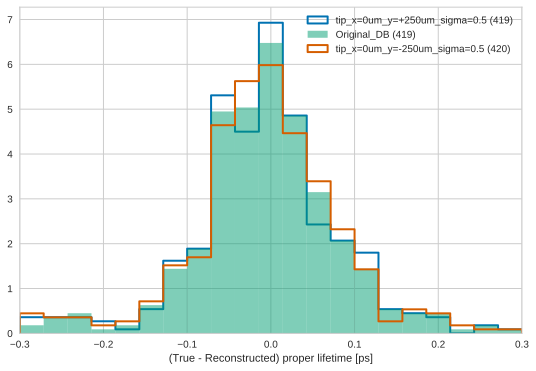

In [31]:
for scenario in scenarios:
    _particles = particles.query(f'(scenario == "{scenario}")')
    res = (_particles.true_proper_time - _particles.proper_time)*1e12
    print(scenario)
    print(f'  median = {res.median():.3f}')
    print(f'    0.5σ = {res.quantile(0.5+sigma[0.5]/2)-res.quantile(0.5-sigma[0.5]/2):.3f}')
    print(f'      1σ = {res.quantile(0.5+sigma[1]/2)-res.quantile(0.5-sigma[1]/2):.3f}')
    label = f'{scenario} ({len(res)})'
    if scenario == 'Original_DB':
        res.hist(bins=np.linspace(-3e-1, 3e-1, 22), label=label, alpha=0.5, normed=True)
    else:
        res.hist(bins=np.linspace(-3e-1, 3e-1, 22), label=label, normed=True, histtype='step', lw=2)
plt.legend(loc='best')
plt.xlim((-3e-1, 3e-1))
plt.xlabel('(True - Reconstructed) proper lifetime [ps]')